## NYS coronavirus data 

Data from health.data.ny.gov

In [1]:
import pandas as pd
from sodapy import Socrata
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("health.data.ny.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(health.data.ny.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("xdss-u53e",limit=200000) #limit = 62 counties in NY

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

results_df

,test_date,county,new_positives,cumulative_number_of_positives,total_number_of_tests,cumulative_number_of_tests
0,2020-04-21T00:00:00.000,Albany,33,737,236,7535
1,2020-04-21T00:00:00.000,Allegany,0,30,10,379
2,2020-04-21T00:00:00.000,Bronx,879,30868,2942,65304
3,2020-04-21T00:00:00.000,Broome,14,219,54,1527
4,2020-04-21T00:00:00.000,Cattaraugus,2,37,34,514
...,...,...,...,...,...,...
3157,2020-03-02T00:00:00.000,Washington,0,0,0,0
3158,2020-03-02T00:00:00.000,Wayne,0,0,0,0
3159,2020-03-02T00:00:00.000,Westchester,1,1,1,1
3160,2020-03-02T00:00:00.000,Wyoming,0,0,0,0


In [2]:
#Define some dataframes
df_tot_pos = results_df.drop(columns={'total_number_of_tests','cumulative_number_of_tests','new_positives'})
df_daily_pos = results_df.drop(columns={'total_number_of_tests','cumulative_number_of_tests','cumulative_number_of_positives'})

df_tot_tests = results_df.drop(columns={'total_number_of_tests','cumulative_number_of_positives','new_positives'})
df_daily_tests = results_df.drop(columns={'cumulative_number_of_tests','cumulative_number_of_positives','new_positives'})

#make a list of days (no duplicates)
days = results_df['test_date'].drop_duplicates()

In [3]:
#Reformat function 
def reformat(df_in):
    df_temp = df_in.loc[results_df['test_date'] == days.iloc[0]]

    df_temp = df_temp.drop(columns='test_date')
    dft_temp = df_temp.T
    dft_temp = dft_temp.reset_index()
    new_header = dft_temp.iloc[0] #grab the first row for the head

    #create df, index as date
    df = pd.DataFrame(columns = new_header)

    #loop for each day in date list
    for i in range(len(days)):
        today = days.iloc[i]
        
        #get total positive for i-th day from results df
        df_today = df_in.loc[results_df['test_date'] == days.iloc[i]]
        df_today.drop(columns='test_date',inplace=True)
    
        #Pivot
        dft = df_today.T
        new_header = dft.iloc[0] #grab the first row for the header
        df_temp = dft[1:] #take the data less the header row
        
        #Clear NaN/0
        df_temp = df_temp.astype(str).astype(int)
        df_temp.fillna('0', inplace=True)
        
        df_temp.columns = new_header
    
        df_temp['dates'] = today 
        df = df.append(df_temp,ignore_index = False,sort=True)

    #More reformatting
    df.drop(['county'],axis=1,inplace=True)

    #make date-time nicer
    df.dates = pd.to_datetime(df.dates, yearfirst = True, format='%Y-%m-%dT%H:%M:%S.%f')
    df.dates = df['dates'].dt.strftime('%m/%d/%Y')
    df.set_index('dates',inplace=True)

    df = df.iloc[1:]
    
    #Crease total number of cases 
    df["sum"] = df.sum(axis=1)

    df.sort_values('dates',ascending=True,inplace=True)
    
    return df

In [4]:
#Use function on extracted data
df_pos = reformat(df_tot_pos)
df_daily_pos = reformat(df_daily_pos)

df_test = reformat(df_tot_tests)
df_daily_test = reformat(df_daily_tests)

#Lets see 
df_pos.tail()

/Users/ericoliverio/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Albany,Allegany,Bronx,Broome,Cattaraugus,Cayuga,Chautauqua,Chemung,Chenango,Clinton,...,Tioga,Tompkins,Ulster,Warren,Washington,Wayne,Westchester,Wyoming,Yates,sum
dates,,,,,,,,,,,,,,,,,,,,,
04/16/2020,619,29,27035,178,34,36,25,71,76,47,...,30,117,788,91,48,49,22476,35,8,229642.0
04/17/2020,648,30,28019,186,34,36,25,72,77,48,...,32,117,820,94,52,49,23179,36,9,236732.0
04/18/2020,682,30,28823,192,34,36,25,73,78,49,...,35,117,854,96,63,50,23803,36,9,242786.0
04/19/2020,687,30,29372,199,34,36,25,73,78,51,...,37,119,877,101,65,50,24306,36,10,247512.0
04/20/2020,704,30,29989,205,35,36,25,75,79,51,...,37,119,893,102,68,51,24656,36,10,251690.0


## Top Counties

In [5]:
#top 10 counties
dft = df_pos.T
today = len(dft.columns)-1
df_top = dft.sort_values(dft.columns[today], ascending = False)

df_top.head(13) #Buffalo/Erie is 13th!

dates,03/02/2020,03/03/2020,03/04/2020,03/05/2020,03/06/2020,03/07/2020,03/08/2020,03/09/2020,03/10/2020,03/11/2020,...,04/11/2020,04/12/2020,04/13/2020,04/14/2020,04/15/2020,04/16/2020,04/17/2020,04/18/2020,04/19/2020,04/20/2020
sum,1,1,3,25,36,60,88,151,195,251,...,188694,195031,202208,213779,222284,229642,236732,242786,247512,251690
Queens,0,0,0,1,2,2,3,3,7,12,...,32835,33985,35053,36765,37918,39091,40216,41237,42023,42822
Kings,0,0,1,1,4,4,6,7,14,16,...,27471,28404,29306,31969,33521,34705,35763,36482,37030,37694
Nassau,0,0,0,1,4,6,10,14,20,31,...,23553,24358,25250,26715,27772,28539,29180,30013,30677,31079
Bronx,0,0,0,0,0,0,1,5,5,7,...,21441,22205,23266,24653,25932,27035,28019,28823,29372,29989
Suffolk,0,0,0,0,0,0,1,1,6,11,...,20816,21643,22462,23278,24182,25035,26143,26888,27662,28154
Westchester,1,1,1,20,20,42,60,102,111,132,...,19313,19786,20191,20947,21828,22476,23179,23803,24306,24656
New York,0,0,1,2,5,5,5,12,24,27,...,14145,14501,14880,16617,17091,17490,17932,18220,18468,18699
Richmond,0,0,0,0,0,0,0,0,1,2,...,7316,7668,7960,8298,8684,9031,9333,9674,9913,10121
Rockland,0,0,0,0,1,1,1,4,4,6,...,7721,7965,8335,8474,8752,8987,9171,9364,9457,9568


In [6]:
#Bar chart

# Total positive cases

/Users/ericoliverio/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


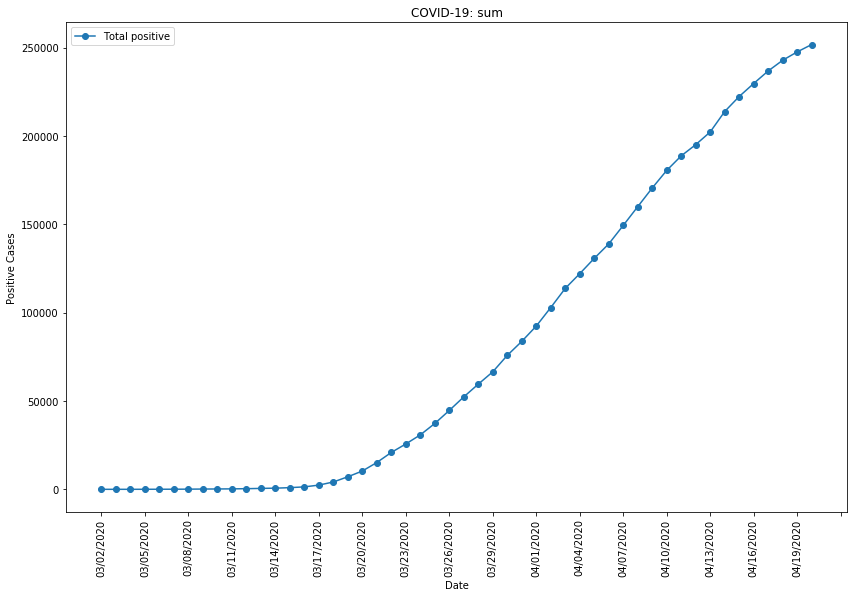

In [7]:
#Total positive 
plt.figure(figsize=(14,9))

state = 'sum'
plt.plot_date(df_pos.index,df_pos[state].values,label='Total positive',ls='-')
#plt.plot_date(df.dates,df.Bronx.values,label='Bronx',ls='-')


plt.xticks(rotation='vertical')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.title('COVID-19: '+str(state))
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();
plt.show()

# Daily cases

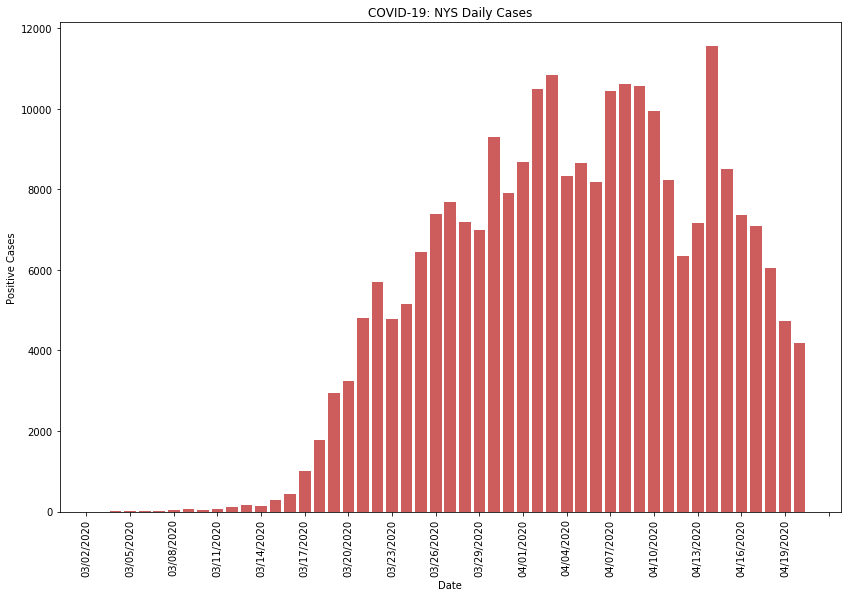

In [8]:
diff = df_pos.diff()
#can also use df_daily_pos

plt.figure(figsize=(14,9))

#plt.bar(df_pos.index, df_pos['Erie'].values,color='indianred')
plt.bar(diff.index, diff['sum'].values,color='indianred')

#ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.title('COVID-19: NYS Daily Cases')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.show()

# Growth factor and 3-day rolling average

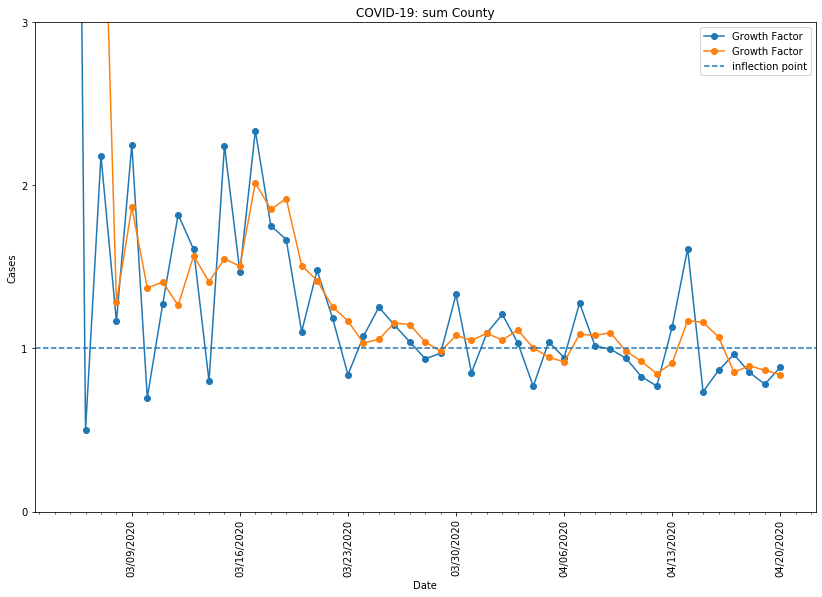

In [17]:
window = 3
state = 'sum'

diff = df_pos.diff()
gf = diff.pct_change()+1
rol = gf.rolling(window).sum()/window

plt.figure(figsize=(14,9))

plt.plot_date(gf.index,gf[state].values,label='Growth Factor',ls='-')
plt.plot_date(rol.index,rol[state].values,label='Growth Factor',ls='-')


plt.xticks(rotation='vertical')
plt.title('COVID-19: '+str(state)+' County')
plt.ylabel('Cases')
plt.xlabel('Date')

ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.axhline(1,ls='--',label='inflection point')
leg = plt.legend();
plt.ylim([0, 3])

plt.show()

# NYC

We saw Queens, Brooklyn, and the Bronx have the highest cases, respectively.

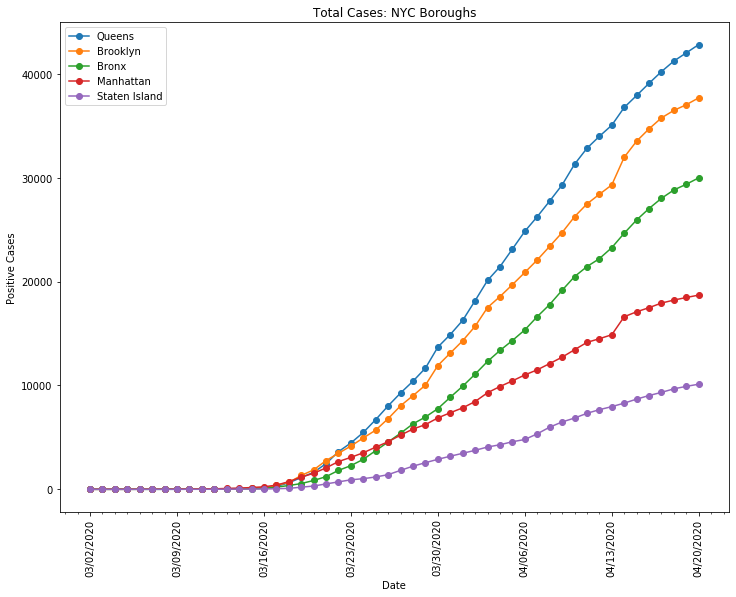

In [10]:
plt.figure(figsize=(12,9))
ax=plt.gca()
#plt.plot_date(df.index,df.Bronx.values,label='Bronx',ls='-')
plt.plot_date(df_pos.index,df_pos['Queens'].values,label='Queens',ls='-')
plt.plot_date(df_pos.index,df_pos['Kings'].values,label='Brooklyn',ls='-')

plt.plot_date(df_pos.index,df_pos['Bronx'].values,label='Bronx',ls='-')
plt.plot_date(df_pos.index,df_pos['New York'].values,label='Manhattan',ls='-')

plt.plot_date(df_pos.index,df_pos['Richmond'].values,label='Staten Island',ls='-')

plt.title('Total Cases: NYC Boroughs')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xticks(rotation='vertical')
ax=plt.gca()
plt.show()

# Erie county

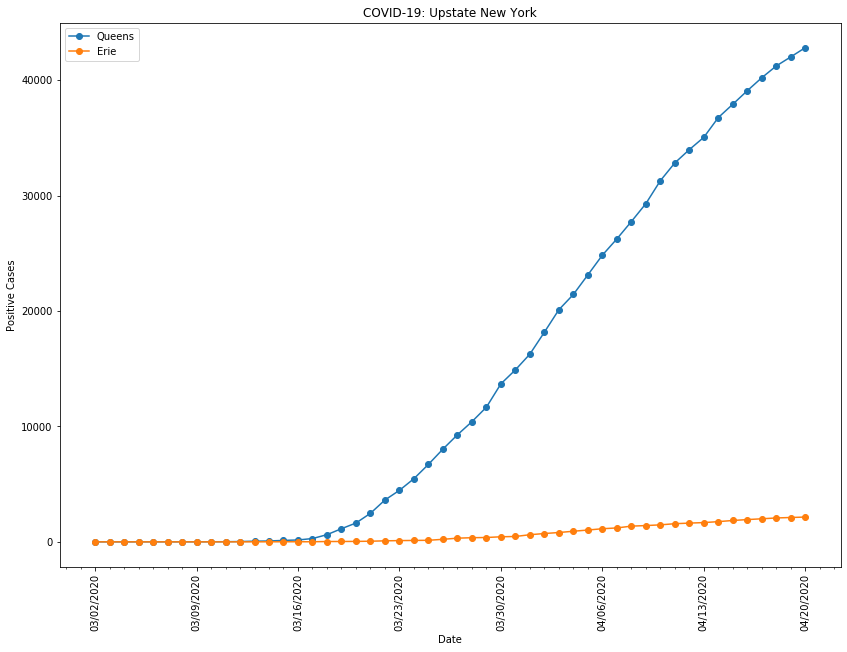

In [11]:
plt.figure(figsize=(14,10))

plt.plot_date(df_pos.index,df_pos['Queens'].values,label='Queens',ls='-')
plt.plot_date(df_pos.index,df_pos.Erie.values,label='Erie',ls='-')


plt.title('COVID-19: Upstate New York')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();

ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.xticks(rotation='vertical')

plt.show()

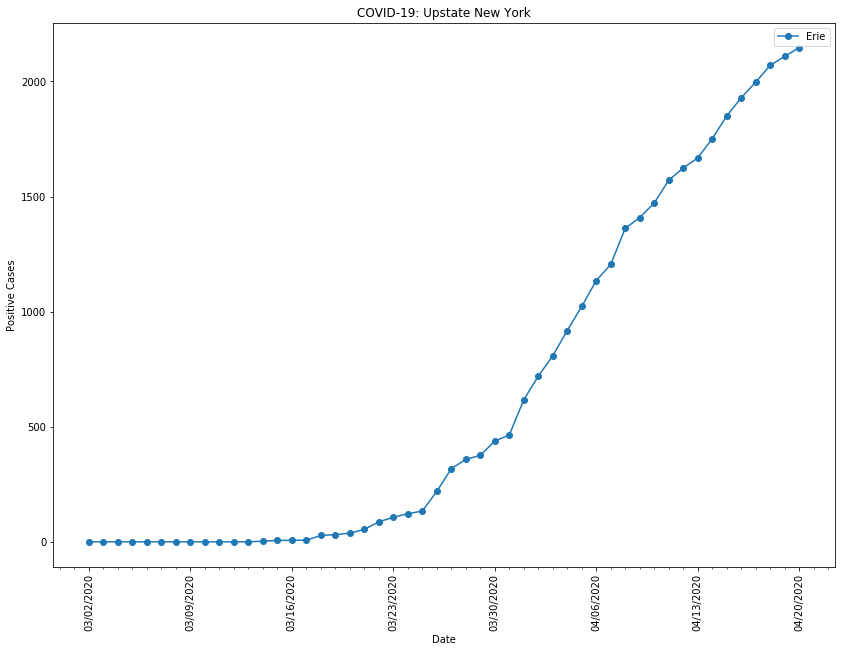

In [12]:
plt.figure(figsize=(14,10))

#plt.plot_date(df_pos.index,df_pos['Queens'].values,label='Queens',ls='-')
plt.plot_date(df_pos.index,df_pos.Erie.values,label='Erie',ls='-')


plt.title('COVID-19: Upstate New York')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
leg = plt.legend();

ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.xticks(rotation='vertical')

plt.show()

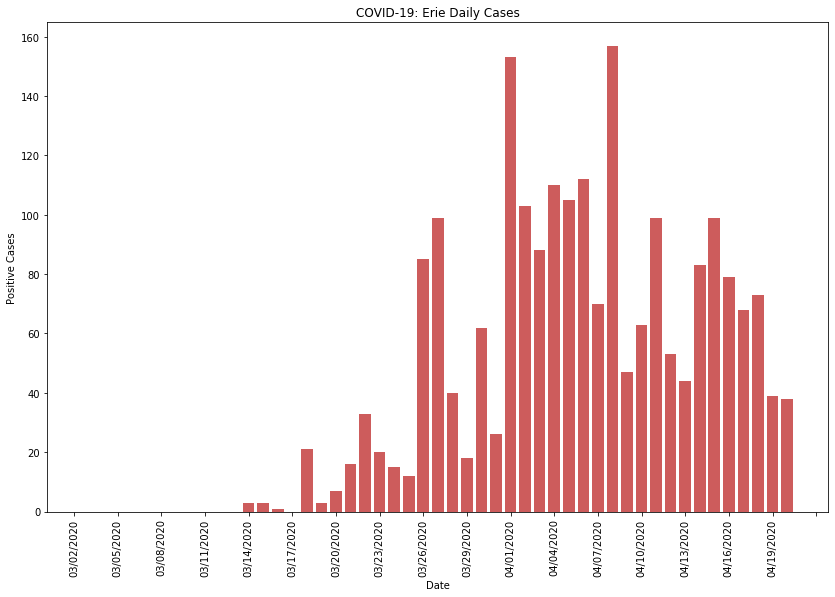

In [13]:
diff = df_pos.diff()
#can also use df_daily_pos

plt.figure(figsize=(14,9))

#plt.bar(df_pos.index, df_pos['Erie'].values,color='indianred')
plt.bar(diff.index, diff['Erie'].values,color='indianred')

#ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.title('COVID-19: Erie Daily Cases')
plt.ylabel('Positive Cases')
plt.xlabel('Date')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.show()

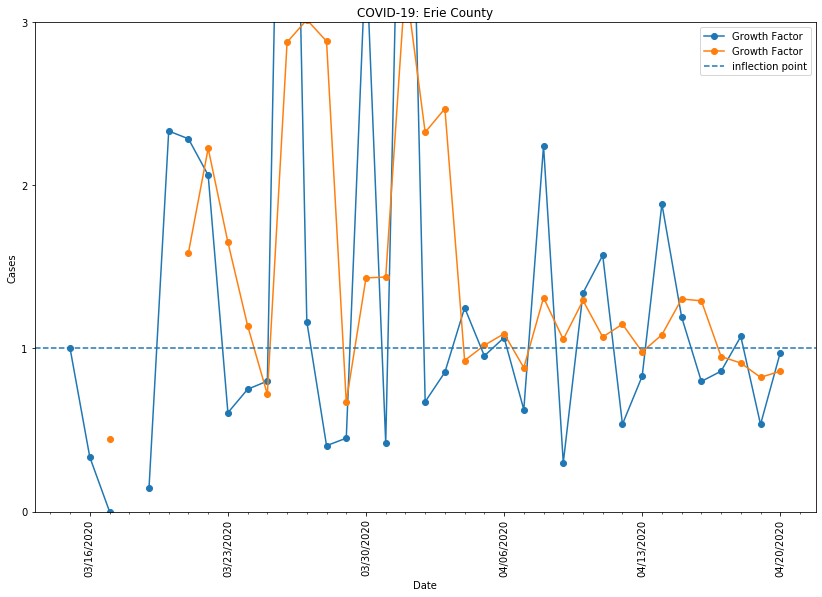

In [18]:
#Make function
window = 3
state = 'Erie'
#---
diff = df_pos.diff()
gf = diff.pct_change()+1
rol = gf.rolling(window).sum()/window

plt.figure(figsize=(14,9))

plt.plot_date(gf.index,gf[state].values,label='Growth Factor',ls='-')
plt.plot_date(rol.index,rol[state].values,label='Growth Factor',ls='-')

plt.xticks(rotation='vertical')
plt.title('COVID-19: '+str(state)+' County')
plt.ylabel('Cases')
plt.xlabel('Date')

ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.axhline(1,ls='--',label='inflection point')
leg = plt.legend();
plt.ylim([0, 3])

plt.show()